In [1]:
# make_seaice_vriles
#
#
# To make vrile files:
# 1) Run compute_deltaseaice_longterm_means
#    --> Creates the long-term climatology files necessary for calculations in Part 2) below.
# 2) Run make_seaice_climatology_file
#    --> Creates another long-term climatology file necessary for plots (but not in the calculations of VRILEs themselves)
# 3) Run make_seaice_vriles
#    --> filter_option 'butterworth' and 'mean_removed' with percentiles = [5, 95]
#    --> Annual and all seasons
#    --> Repeat the above 2 steps with dtUniqueCase = 1
#    --> Repeat steps 1 and 2 above with percentiles = [100,100]
# 4) Run merge_lists
#    --> This will create the 'allvriles' files.  
#    --> Need to run annually and for all seasons, as well as with both dtUniqueCase options, as well as for both percentile options
# 5) filter_vriles
#    --> Removes all vriles on last day and first two days of month due to erroneous NSIDC sea ice extent shift.  
#    *** MUST be run after merge_lists ***
#
# Steven Cavallo
# December 2024
#
###########################
# imports
###########################
import matplotlib.pyplot as plt
import numpy as np
import sys, imp
import pylab
import datetime as dt
from datetime import date
import os, datetime
import csv
from scipy.fftpack import fft
from scipy.signal import blackman, butter, lfilter, filtfilt, freqz, periodogram
import gc

import weather_modules as wm
import utilities_modules as um

from mstats import *

/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_79403/1562995434.py:28: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import sys, imp


In [2]:
plot_variable = 'dextent_int' # 'extent','dextent', dextent_int, or dextent_diff
filter_option = 'butterworth' # options are 'nearby', 'butterworth', 'mean_removed', and 'none'
number_days_dextent = 3 # do not go above 3
write_events = 'True'
plot_data = 'False'

months_filter = [1,12]
#months_filter = [3,5]
#months_filter = [6,8]
#months_filter = [9,11]
#months_filter = [12,2]

percentiles = [5,95] # For the data percentiles
#percentiles = [100,100]
dtUniqueCase = 1 # If set to 1, will not count back-to-back daily events as separate events

timeinc = 24 # time between data
label_fontsize = 16

year_range = [1989,2023] # This controls range for observations and large ensemble 

In [3]:
# Set file paths
fpath = '/Users/scavallo/Documents/data/seaice_loss/paper_data_1979_2023/N_seaice_extent_daily_v3.0.csv' 
fpath_climo_daily = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/NH_seaice_daily_dextent_int_longtermmean_errorbars_1989_2018_3d.dat'
fpath_climo_monthly = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/NH_seaice_monthly_dextent_int_longtermmean_errorbars_1989_2018_3d.dat'
event_dir_out = '/Users/scavallo/Documents/data/seaice_loss/paper_data_directory/'
imagedir = '/Users/scavallo/Documents/scripts/python_scripts/images/'

file = open(fpath, 'r')
data = np.loadtxt(file,skiprows=2, delimiter=',',usecols=(0,1,2,3))

In [4]:
if filter_option == 'nearby':
    filtname = 'nearby'
if filter_option == 'none':
    filtname = 'nofilt'
if filter_option == 'butterworth':
    filtname = 'bwfilter'
if filter_option == 'mean_removed':
    filtname = 'meanremoved'

if ( (months_filter[0] == 1) & (months_filter[1] == 12) ):
    timeframe = 'annual'
if ( (months_filter[0] == 3) & (months_filter[1] == 5) ):
    timeframe = 'mam'
if ( (months_filter[0] == 6) & (months_filter[1] == 8) ):
    timeframe = 'jja'
if ( (months_filter[0] == 9) & (months_filter[1] == 11) ):
    timeframe = 'son'
if ( (months_filter[0] == 12) & (months_filter[1] == 2) ):
    timeframe = 'djf'

if dtUniqueCase == 0:
    dtname = ''    
else:
    dtname = '_dtUnique0' + str(dtUniqueCase)

percentilenum = percentiles[0] + (100-percentiles[1])
percstr = str(percentilenum) + 'percentile'
    
event_fname_out = 'rapid_seaice_loss_events_int_withboth_' + timeframe + '_' + filtname + '_3d_' +percstr +  dtname +'.dat'
print(event_fname_out)
event_path_out = event_dir_out + event_fname_out


rapid_seaice_loss_events_int_withboth_annual_meanremoved_3d_10percentile.dat


In [5]:
# read in SIE and figure out dates, interpolate to daily for first decade when data were every other day
#convert individual yr,month,day to time values
years = data[:,0].astype(int) #e.g., 1981
months = data[:,1].astype(int) #e.g., 01
days=data[:,2].astype(int) #e.g., 01
extents = data[:,3] #e.g., 11.345 [10^6km^2]    

nVals = len(extents)
print(nVals)
timeList = [dt.datetime(years[i],months[i],days[i]) for i in range(nVals)]; timeList = np.array(timeList)
  
#interpolate to uniform time grid ("daily" values early on are every 2 days)
tStart = timeList[0]; tEnd = timeList[-1]
nDays = (tEnd-tStart).total_seconds()/(24*3600); nDays = int(nDays)
print('{0} days between {1} {2}'.format(nDays, tStart, tEnd))
times = [tStart+ dt.timedelta(days=i) for i in range(0, nDays)]; times = np.array(times)
  
dTime = [(a-timeList[0]).total_seconds() for a in timeList]
dTimeResample = [(a-timeList[0]).total_seconds() for a in times]
extents = np.interp(dTimeResample, dTime, extents)    

14853
16503 days between 1978-10-26 00:00:00 2024-01-01 00:00:00


In [6]:
# compute delta SIE
# CC moved this forward in the script so we compute 
# dextent before truncating extents with the year_range, and before throwing out leap days
# throwing out leap days before computing delta is especially problematic because it changes ndays near the leap day
# this code looks different but reproduces the original dextent, except near the limits
# because extent is not yet truncated
ndays=number_days_dextent 
dextent = np.zeros_like(extents).astype('f')

if ndays==3:
    dextent[(ndays-2):-(ndays-1)] = extents[ndays:] - extents[0:-ndays] 
    dextent[0:(ndays-2)] = dextent[ndays-2]             # fills first values
    dextent[-(ndays-2):] = dextent[-(ndays-1)]
elif ndays==2:
    dextent[(ndays-1):-(ndays-1)] = extents[ndays:] - extents[0:-ndays] 
    dextent[0] = dextent[1]             # fills first values
    dextent[-1] = dextent[-2]
else:
    dextent[0:-1] = extents[1:] - extents[0:-1] 
    dextent[-1] = dextent[0]

del years, months, days
years = [i.year for i in times]
months = [i.month for i in times]
days = [i.day for i in times]
    
years = np.array(years)
months = np.array(months)
days = np.array(days)

In [7]:
# CC notes 
# now truncate extent and call it "extentfocus" 
# tuncate dextent and call it dextent_int

# eliminate years we don't want and leap days 
[inds]= np.where( (years>=year_range[0]) & (years<=year_range[-1]) & ((months !=2 ) | (days !=29 )))
#[inds] = np.where( (years>=year_range[0]) & (years<=year_range[-1]) )

timefocus = times[inds]
yearfocus = years[inds]
monthfocus = months[inds]
dayfocus = days[inds]
extentfocus = extents[inds]

In [8]:
if plot_variable == 'dextent_int':
    ndays = number_days_dextent
    dextent_int = dextent[inds]
    
if plot_variable == 'dextent_diff':
    ndays = number_days_dextent
    dextent_int = dextent[inds]

if plot_variable == 'extent':
    datain = extentfocus
if plot_variable == 'dextent':
    datain = dextent
if plot_variable == 'dextent_int':
    datain = dextent_int
if plot_variable == 'dextent_diff':
    datain = dextent_int 


extent_filt = extentfocus # extents[inds]
#dextent_filt = datain     #dextent[inds]
datain_unfiltered = datain

In [9]:
if filter_option == 'butterworth':
    #butter_order = 3
    butter_order = 12
    sample_days = 1.0 # days
    lowcut_days = 18.0 # days

    sample_rate = sample_days*24.0*3600.0 # convert to seconds
    lowcut = lowcut_days*24.0*3600.0 # convert to seconds
 
    sample_freq = 1.0/sample_rate
    lowcut_freq = 1.0/lowcut # convert to Hz
    nyq = 0.5*sample_freq

    lowcut = lowcut_freq/nyq

    b, a = butter(butter_order,lowcut,btype='highpass')
    #datain_unfiltered = datain
    datain_mean = np.nanmean(datain)
    data_bw = filtfilt(b,a,datain)
    if ( (plot_variable == 'dextent_int') or (plot_variable == 'dextent_diff' ) ):
        extent_filt = extentfocus
        dextent_filt = data_bw
    
        extent_filt = np.zeros_like(extentfocus).astype('f')
        extent_filt[0] = extentfocus[180]
        for ii in range(len(extent_filt)-1):
            extent_filt[ii+1] = extent_filt[ii] + dextent_filt[ii]


In [10]:
if filter_option == 'mean_removed':
    ab = np.loadtxt(fpath_climo_monthly, skiprows=0)       
    #dextent_monthly_percentile = ab[:,9] # 10th percentile
    dextent_monthly_percentile = ab[:,7]  # 5th percentile    
    
    ab = np.loadtxt(fpath_climo_daily, skiprows=0)       
    month_climo = ab[:,0]
    day_climo = ab[:,1]
    extent_climo = ab[:,2]
    dextent_climo = ab[:,3]
    
    dextent_percentile = np.zeros_like(extentfocus).astype('f')
    
    tt = 0
    while tt < len(extentfocus):
        mm = monthfocus[tt]
        dd = dayfocus[tt]
        
        [anomind] = np.where( (month_climo == int(mm)) & (day_climo == int(dd)))
        
        if (not anomind):
            anomind = 1
            extent_anom_now = float('NaN')
        else:    
            #dextent_anom_now = dextent_nofilt[tt] - dextent_climo[anomind]
            extent_anom_now = extentfocus[tt] - extent_climo[anomind]
        
        extent_filt[tt] = extent_anom_now
        dextent_percentile[tt] = dextent_monthly_percentile[mm-1]
 
        tt += 1
    
    dextent_filt = np.zeros_like(extent_filt).astype('f')
    if ndays==3:
        dextent_filt[(ndays-2):-(ndays-1)] = extent_filt[ndays:] - extent_filt[0:-ndays] 
        dextent_filt[0:(ndays-2)] = dextent_filt[ndays-2]             # fills first values
        dextent_filt[-(ndays-2):] = dextent_filt[-(ndays-1)]
    elif ndays==2:
        dextent_filt[(ndays-1):-(ndays-1)] = extent_filt[ndays:] - extent_filt[0:-ndays] 
        dextent_filt[0] = dextent_filt[1]             # fills first values
        dextent_filt[-1] = dextent_filt[-2]
    else:
        dextent_filt[0:-1] = extent_filt[1:] - extent_filt[0:-1] 
        dextent_filt[-1] = dextent_filt[0]

/var/folders/xq/7hcvmpk52glfnlmbm30s1lkc0000gq/T/ipykernel_79403/2237981129.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  extent_filt[tt] = extent_anom_now


In [11]:
mstats(extent_filt)
mstats(dextent_filt)

 
MatrixSize =  12775
MatrixShape =  (12775,)
NElements =  12775
NAnalyzedElements =  12740
Mean =  -0.11232311616954473
Median =  -0.11619999999999919
Max =  2.2428
Min =  -2.846000000000001
Range =  5.088800000000001
StDev =  0.7127806297572665
MeanAbs =  0.5815822527472527
MinAbs =  9.999999999976694e-05
FracZero =  0.00015698587127158556
FracNaN =  0.0027397260273972603
 
MatrixSize =  12775
MatrixShape =  (12775,)
NElements =  12775
NAnalyzedElements =  12705
Mean =  -0.00012158978
Median =  0.0
Max =  0.632
Min =  -0.4513
Range =  1.0833
StDev =  0.10265516
MeanAbs =  0.07893376
MinAbs =  1.7763568e-15
FracZero =  0.0006296733569460842
FracNaN =  0.005479452054794521


In [12]:
upper_lim = percentiles[1]
lower_lim = percentiles[0]

uq_arr = np.zeros_like(dextent).astype('f')
lq_arr = np.zeros_like(dextent).astype('f')
uq_arr_filt = np.zeros_like(dextent_filt).astype('f')
lq_arr_filt = np.zeros_like(dextent_filt).astype('f')

uq = np.nanpercentile(dextent, upper_lim)
lq = np.nanpercentile(dextent, lower_lim)
uq_filt = np.nanpercentile(dextent_filt, upper_lim)
lq_filt = np.nanpercentile(dextent_filt, lower_lim)

uq_arr[:] = uq
uq_arr_filt[:] = uq_filt
lq_arr[:] = lq
lq_arr_filt[:] = lq_filt

print("Percentile threshold values: (Upper data / Upper filtered data / Lower data / Lower filtered data)")
print(uq,uq_filt,lq,lq_filt)

Percentile threshold values: (Upper data / Upper filtered data / Lower data / Lower filtered data)
0.34200000762939453 0.16369999945163727 -0.30245000720024107 -0.16928000450134276


In [13]:
if plot_data == 'True':
    year2plot = 2015   
    months2plot = [1,12]
    monthstartinds = [0,31,59,90,120,151,181,212,243,273,304,334]
    #months2plot = [1,4]
   
    [yinds] = np.where( (yearfocus == year2plot) & (monthfocus >=months2plot[0]) & (monthfocus<=months2plot[1]) )

    plot_unfiltered = dextent_int[yinds]
    plot_filtered = dextent_filt[yinds]
    
    t = np.arange(0,len(plot_unfiltered))
    monthstartinds = np.array(monthstartinds).astype(int)
    [tinds] = np.where(monthstartinds<=t[-1])

    
    golden = (pylab.sqrt(5)+1.)/2.
    figprops = dict(figsize=(8., 8./ golden ), dpi=128)    # Figure properties for single and stacked plots
    adjustprops = dict(left=0.15, bottom=0.1, right=0.90, top=0.93, wspace=0.2, hspace=0.2) 
    
    z0 = np.zeros_like(plot_unfiltered).astype('f')
    
    fig = pylab.figure(**figprops)   # New figure  
    ax1 = fig.add_subplot(1, 1, 1)

    p1, = ax1.plot(t,plot_unfiltered,'b',linewidth=3.0,label='Delta Extent')  
    p2, = ax1.plot(t,plot_filtered,'r',linewidth=3.0,label='BW filtered delta Extent')  
    p3, = ax1.plot(t,z0,'k',linewidth=2.0)
    
    ax1.grid(True, linestyle='-')
    ax1.set_ylabel(r'$\Delta$SIE ($\times 10^6$ km$^2$)',fontsize=label_fontsize)
    ax1.set_xlabel('Day',fontsize=label_fontsize)

    #ax1.set_ylim(yticks1[0],yticks1[-1]) 
    #ax1.set_yticks(yticks1) 
    ax1.set_xticks(monthstartinds[tinds])
    #ax1.set_xticklabels(datesave,rotation=rotang,fontsize=14)  
    ax1.set_xlim(t[0],t[-1])
    
    legend = ax1.legend(loc='lower left', shadow=True)
    plt.show()

 
MatrixSize =  12775
MatrixShape =  (12775,)
NElements =  12775
NAnalyzedElements =  12740
Mean =  -0.11232311616954473
Median =  -0.11619999999999919
Max =  2.2428
Min =  -2.846000000000001
Range =  5.088800000000001
StDev =  0.7127806297572665
MeanAbs =  0.5815822527472527
MinAbs =  9.999999999976694e-05
FracZero =  0.00015698587127158556
FracNaN =  0.0027397260273972603
[-0.2628 -0.0398  0.3592  0.3082  0.5012  0.6292 -0.0078 -0.0048  0.2622
  0.5052  0.7412  0.2862  0.5682 -0.1218  0.0292 -0.4468 -0.1528 -0.4888
 -0.4188 -0.0788  0.2332  0.2872 -0.1808  0.2012 -0.1458 -0.2658 -0.4848
 -0.7038 -0.4748 -0.6328 -0.8098 -0.6518 -0.3638 -0.3098 -0.2948]
[-0.2671 -0.0461  0.4289  0.2769  0.4969  0.5739 -0.0301 -0.0851  0.2739
  0.5369  0.7279  0.2519  0.5199 -0.0541 -0.0171 -0.4141 -0.1191 -0.4831
 -0.3621 -0.0611  0.2839  0.3029 -0.2081  0.0959 -0.1611 -0.2071 -0.4821
 -0.7271 -0.4501 -0.5941 -0.8111 -0.6191 -0.3501 -0.3461 -0.2761]
[-0.2132  0.0638  0.4458  0.2428  0.5018  0.5168 -0.0

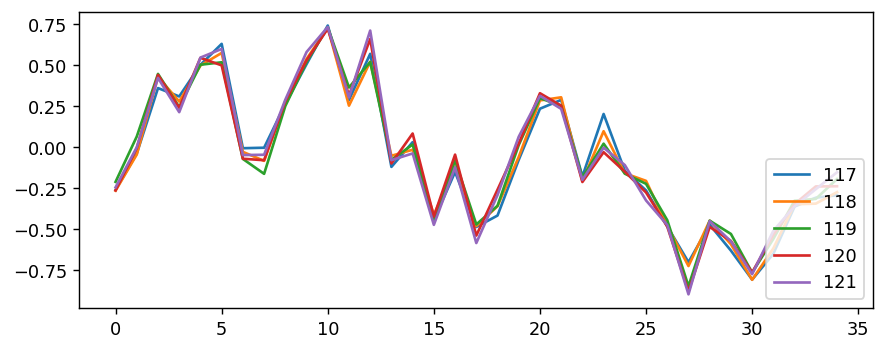

In [14]:
if 1 == 1:
    # shows the weird jump at beginning of month of April, see Meier and Stott (2019) for discussion
    # gist of it is there is a change in the "weather mask" that causes this jump, it is worse some months than others
    #thevar=dextent_filt
    #thevar=datain_unfiltered
    thevar=extentfocus
    mstats(thevar)
    M=119 # also see 150, 180
    figprops = dict(figsize=(8., 3. ), dpi=128)    # Figure properties for single and stacked plots
    fig = pylab.figure(**figprops)   # New figure
    for m in np.arange(M-2,M+3):
        ii=np.arange(m,len(thevar),365)
        #print(ii)
        print(thevar[ii])
        plt.plot(thevar[ii],label=str(m))
    plt.legend(loc='lower right')


In [15]:
if write_events == 'True':
    monthMin = months_filter[0]
    monthMax = months_filter[1]

    
    vals = dextent_filt
    vals_nofilt = datain_unfiltered #dextent # SMC
    #thresh = np.percentile(vals, lower_lim)
    #thresh_nofilt = np.percentile(vals_nofilt, lower_lim)
    thresh = lq_filt
    thresh_nofilt = lq
    
    if filter_option == 'mean_removed':
        thresh = 9999999.
        thresh_nofilt = 9999999.
    
    #thresh = 0.
    #thresh_nofilt = 0.
    print(thresh, thresh_nofilt)
    print('{0}% threshold for dExtent: {1}'.format(lower_lim,thresh))
  
    caseDates = timefocus[vals<=thresh]
    caseVals = vals[vals<=thresh]

    
    #caseDates_nofilt = timefocus[vals<=thresh_nofilt]
    caseDates_nofilt = timefocus[vals<=thresh]
    caseVals_nofilt = vals_nofilt[vals<=thresh]
    
 
    if filter_option == 'mean_removed':       
        caseThreshes = dextent_percentile[vals<=thresh]
        caseThreshes_nofilt = dextent_percentile[vals<=thresh]
    
    #print caseDates.tolist()
    ncandidates1 = np.size(caseDates)
    ncandidates1_nofilt = np.size(caseDates_nofilt)

    #filter candidate cases - season, too close in time,... ------------------------
    #get only w/in specified month range
    print('Limiting to months between: ', monthMin, monthMax)
    #caseDates = [t0 for t0 in caseDates if ((t0.month>=monthMin) and (t0.month<=monthMax)) ]
    #ncandidates2 = np.size(caseDates)
    print(ncandidates1,ncandidates1_nofilt)

    casedate_now = []
    caseval_now = []
    casedate_now_nofilt = []
    caseval_now_nofilt = [] 
    for iCase in range(ncandidates1-1):
        casenow = caseDates[iCase]
        casevalnow = caseVals[iCase]
        casenow_nofilt = caseDates_nofilt[iCase]
        casevalnow_nofilt = caseVals_nofilt[iCase]
        
        if filter_option == 'mean_removed':
            threshnow = caseThreshes[iCase]
            caseLogic = False
            
            #print('Casevalnow_nofilt is %5.2f and threshnow is %5.2f' %(casevalnow_nofilt, threshnow))
            if (casevalnow_nofilt <= threshnow):
                caseLogic = True
        else:
            caseLogic = True
                
        casenext = caseDates[iCase+1]
        
        
        #if ( (caseDates[iCase+1]-caseDates[iCase] > dtUniqueCase) and (casenow.month>=monthMin) and (casenow.month<=monthMax) and (caseLogic == True)):
        if monthMin <= monthMax:
            if (  (casenow.month>=monthMin) and (casenow.month<=monthMax) and (caseLogic == True)):
            #if (  ( (casenow.month>=monthMin) or (casenow.month<=monthMax)) and (caseLogic == True) ):
            #if ( (deltadaysnow > 1) and (casenow.month>=monthMin) and (casenow.month<=monthMax) and (caseLogic == True)):           
                casedate_now.append(casenow)
                caseval_now.append(casevalnow)
                casedate_now_nofilt.append(casenow_nofilt)
                caseval_now_nofilt.append(casevalnow_nofilt)
        if monthMin > monthMax:
            if (  ( (casenow.month>=monthMin) or (casenow.month<=monthMax)) and (caseLogic == True) ):
                casedate_now.append(casenow)
                caseval_now.append(casevalnow)
                casedate_now_nofilt.append(casenow_nofilt)
                caseval_now_nofilt.append(casevalnow_nofilt)            

    ncandidates2 = np.size(casedate_now)
    ncandidates2_nofilt = np.size(casedate_now_nofilt)
    print(ncandidates1,ncandidates2)
    print(ncandidates1_nofilt,ncandidates2_nofilt)

    #take out dates w/ missing values
    validDates = []
    validVals = []
    ind = 0
    for t0 in casedate_now:
        #19870709 is first file in 1987
        if (t0<dt.datetime(1987,1,1) or t0>dt.datetime(1987,7,8) ):
            validDates.append(t0)
            validVals.append(caseval_now[ind])
        ind += 1    
    print('Kept {0}/{1} event dates not known to have missing sea ice values'.format(len(casedate_now),len(validDates)))

    validVals_nofilt = []
    validDates_nofilt = []
    ind = 0
    for t0 in casedate_now_nofilt:
        #19870709 is first file in 1987
        if (t0<dt.datetime(1987,1,1) or t0>dt.datetime(1987,7,8) ):
            validDates_nofilt.append(t0)
            validVals_nofilt.append(caseval_now_nofilt[ind])
        ind += 1    
    print('Kept {0}/{1} event dates not known to have missing sea ice values'.format(len(casedate_now),len(validDates)))    
    
    ncandidates_missingvalues = np.size(validDates)
    
    # Now need to check for back-to-back events
    if 1 == 1:
        validDates_check = []
        validVals_check = []
        validDates_nofilt_check = []
        validVals_nofilt_check = []
        
        count = 0
        for t0 in validDates:
            #print(count,len(validDates))
            if count < len(validDates)-1:
                casenow = validDates[count]
                casenext = validDates[count+1]
         
                aa = date(casenow.year,casenow.month,casenow.day)
                bb = date(casenext.year,casenext.month,casenext.day)
                deltadaysnow = (bb-aa).days
                #print(aa,bb,deltadaysnow,dtUniqueCase)
                
                if (int(deltadaysnow) > dtUniqueCase):
                    validDates_check.append(validDates[count])
                    validVals_check.append(validVals[count])
                    validDates_nofilt_check.append(validDates_nofilt[count])
                    validVals_nofilt_check.append(validVals_nofilt[count])
    
            if count == len(validDates)-1:
                del validDates, validDates_nofilt, validVals, validVals_nofilt
                validDates = validDates_check
                validDates_nofilt = validDates_nofilt_check
                validVals = validVals_check
                validVals_nofilt = validVals_nofilt_check
                
            count += 1
    
    ncandidates_final = np.size(validDates)
    ncandidates_final_nofilt = np.size(validDates_nofilt)
    
    
    print('Number of percentile candidates: %d' %(ncandidates1))
    print('After limiting by missing values: %d' %(ncandidates_missingvalues))
    print('After limiting by month range: %d' %(ncandidates2))
    print('After limiting by adjacent days: %d' %(ncandidates_final))
    #print('After limiting by days apart: %d' %(ncandidates3))
    

    yearsprint = [i.year for i in validDates]
    monthsprint = [i.month for i in validDates]
    daysprint = [i.day for i in validDates]
    
    datesprint = []
    for ii in range(0,len(yearsprint)):
        if monthsprint[ii] < 10:
            monthnow = '0' + str(monthsprint[ii])
        else:
            monthnow = str(monthsprint[ii])
        if daysprint[ii] < 10:
            daynow = '0' + str(daysprint[ii])
        else:
            daynow = str(daysprint[ii])            
        datenow = str(yearsprint[ii]) + monthnow + daynow + '00'
        datesprint.append(datenow)
      
    #print(datesprint)
    gc.collect()
    outfile = open(event_path_out,'w')
    wcount = 0
    for ii in range(0,len(datesprint)):
        print(datesprint[ii],validVals[ii],validVals_nofilt[ii])
        datesprintnow = np.array(datesprint[ii],dtype='int')
        outfile.write('%-10s %7.4f %7.4f\n' % (datesprintnow, validVals[ii], validVals_nofilt[ii] ))

9999999.0 9999999.0
5% threshold for dExtent: 9999999.0
Limiting to months between:  1 12
12705 12705
12705 645
12705 645
Kept 645/645 event dates not known to have missing sea ice values
Kept 645/645 event dates not known to have missing sea ice values
Number of percentile candidates: 12705
After limiting by missing values: 645
After limiting by month range: 645
After limiting by adjacent days: 644
1989012800 -0.1998 -0.111
1989012900 -0.2219 -0.141
1989021000 -0.2249 -0.194
1989021100 -0.2158 -0.17
1989021500 -0.2179 -0.151
1989030700 -0.3248 -0.324
1989030800 -0.2612 -0.258
1989033100 -0.176 -0.288
1989040100 -0.1847 -0.315
1989041200 -0.1844 -0.299
1989041600 -0.1733 -0.306
1989070100 -0.1118 -0.488
1989071800 -0.1849 -0.442
1989111100 -0.1646 0.017
1990010300 -0.1967 -0.081
1990021100 -0.2108 -0.165
1990021200 -0.2601 -0.194
1990031400 -0.1898 -0.22
1990031500 -0.2919 -0.314
1990031600 -0.287 -0.32
1990031700 -0.2235 -0.265
1990031800 -0.1857 -0.232
1990032500 -0.2307 -0.261
19900